In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [2]:
target_countries = ['DEU', 'CZE', 'AUT', 'POL', 'SVK']

regions = gpd.read_parquet('/data/uscuni-ulce/regions/cadastre_regions_hull.parquet')

fuas = gpd.read_file('/data/uscuni-boundaries/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')
fuas = fuas[fuas.Cntry_ISO.isin(target_countries)]
fuas = fuas.to_crs(epsg=3035)

In [3]:
fuas

,eFUA_ID,UC_num,UC_IDs,eFUA_name,Commuting,Cntry_ISO,Cntry_name,FUA_area,UC_area,FUA_p_2015,UC_p_2015,Com_p_2015,geometry
252,8.0,1.0,2788,Innsbruck,1.0,AUT,Austria,352.0,27.0,244610.309811,113300.718506,131309.591305,"MULTIPOLYGON (((4443566.755 2690941.982, 44454..."
253,199.0,1.0,2885,Salzburg,1.0,AUT,Austria,368.0,46.0,261062.845268,140052.170959,121010.674308,"MULTIPOLYGON (((4560286.656 2759415.026, 45612..."
254,361.0,1.0,2936,Linz,1.0,AUT,Austria,875.0,69.0,417919.471337,202651.519836,215267.951500,"MULTIPOLYGON (((4645121.405 2822486.965, 46536..."
255,511.0,1.0,2952,Klagenfurt,1.0,AUT,Austria,462.0,26.0,152986.515700,64018.369995,88968.145705,"MULTIPOLYGON (((4656176.355 2638266.258, 46571..."
256,654.0,1.0,3000,Graz,1.0,AUT,Austria,978.0,73.0,441137.873177,261476.193604,179661.679573,"MULTIPOLYGON (((4723593.134 2695741.13, 472455..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7673,327.0,1.0,3104,Trnava,1.0,SVK,Slovakia,537.0,16.0,139857.330934,52550.098022,87307.232911,"MULTIPOLYGON (((4875444.247 2848478.714, 48801..."
7674,480.0,1.0,3155,Žilina,1.0,SVK,Slovakia,534.0,21.0,181681.640991,61025.274475,120656.366516,"MULTIPOLYGON (((4961408.815 2951386.993, 49604..."
7675,623.0,1.0,3182,Banská Bystrica,1.0,SVK,Slovakia,323.0,22.0,126248.723860,59149.840820,67098.883040,"MULTIPOLYGON (((4989472.704 2899534.991, 49904..."
7676,760.0,1.0,3265,Prešov,1.0,SVK,Slovakia,425.0,20.0,162125.056025,66394.822998,95730.233027,"MULTIPOLYGON (((5129516.429 2949839.008, 51304..."


In [4]:
%%time

results = []

for region_id in regions.index:
    
    region_buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_v3.pq')
    
    # assign polygons to only one fua
    inp, res = region_buildings.sindex.query(fuas.geometry, predicate='intersects')
    # polygons should be assigned to only one fua
    duplicated = pd.Series(res).duplicated()
    inp = inp[~duplicated]
    res = res[~duplicated]
    
    # keep only fua buildings and record  fua 'country', 'city', 'population'
    region_buildings = region_buildings.iloc[res]
    region_buildings.loc[:, ['city', 'country', 'population']] = fuas.iloc[inp, [3, 5, 9]].values

    results.append(region_buildings)

all_fua_buildings = pd.concat(results, ignore_index=True)

CPU times: user 1min 53s, sys: 8.82 s, total: 2min 2s
Wall time: 1min 51s


In [5]:
all_fua_buildings.iloc[:100].explore()

In [6]:
mapping = pd.read_parquet(
    "/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v3.pq"
)

In [7]:
subset = all_fua_buildings[['country', 'city', 'final_without_noise']]
subset['final_without_noise'] = subset.final_without_noise.map(mapping[4].to_dict())

/tmp/ipykernel_6781/1612430713.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['final_without_noise'] = subset.final_without_noise.map(mapping[4].to_dict())


In [8]:
%%time
res = subset.groupby(['country', 'city', 'final_without_noise'])['final_without_noise'].count()
res = res.unstack(-1).fillna(0).astype(int)

CPU times: user 1.31 s, sys: 245 ms, total: 1.56 s
Wall time: 1.56 s


In [9]:
X = res.values / res.sum(axis=1).values[:, np.newaxis]

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X)

In [11]:
df = pd.DataFrame(components, columns=['PC1', 'PC2'])
df['city'] = res.index.get_level_values(1).values
df['country'] = res.index.get_level_values(0).values

In [13]:
def generate_pca_plot_at_level(level):
    subset = all_fua_buildings[['country', 'city', 'final_without_noise']]
    if level < 7:
        subset.loc[:, 'final_without_noise'] = subset.final_without_noise.map(mapping[level].to_dict())
    res = subset.groupby(['country', 'city', 'final_without_noise'])['final_without_noise'].count()
    res = res.unstack(-1).fillna(0).astype(int)
    X = res.values / res.sum(axis=1).values[:, np.newaxis]
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    print(pca.explained_variance_, pca.explained_variance_ratio_)
    df = pd.DataFrame(components, columns=['PC1', 'PC2'])
    df.loc[:, 'city'] = res.index.get_level_values(1).values
    df.loc[:, 'country'] = res.index.get_level_values(0).values
    return df

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

[0.01710804 0.00593765] [0.31507762 0.10935323]
[0.02585014 0.00727252] [0.40633962 0.11431717]
[0.03579096 0.01161795] [0.47265887 0.1534278 ]
[0.05708079 0.01390008] [0.58355179 0.14210415]
[0.05542404 0.01639664] [0.59833616 0.17701171]
[0.08052376 0.0185778 ] [0.73519897 0.16961921]


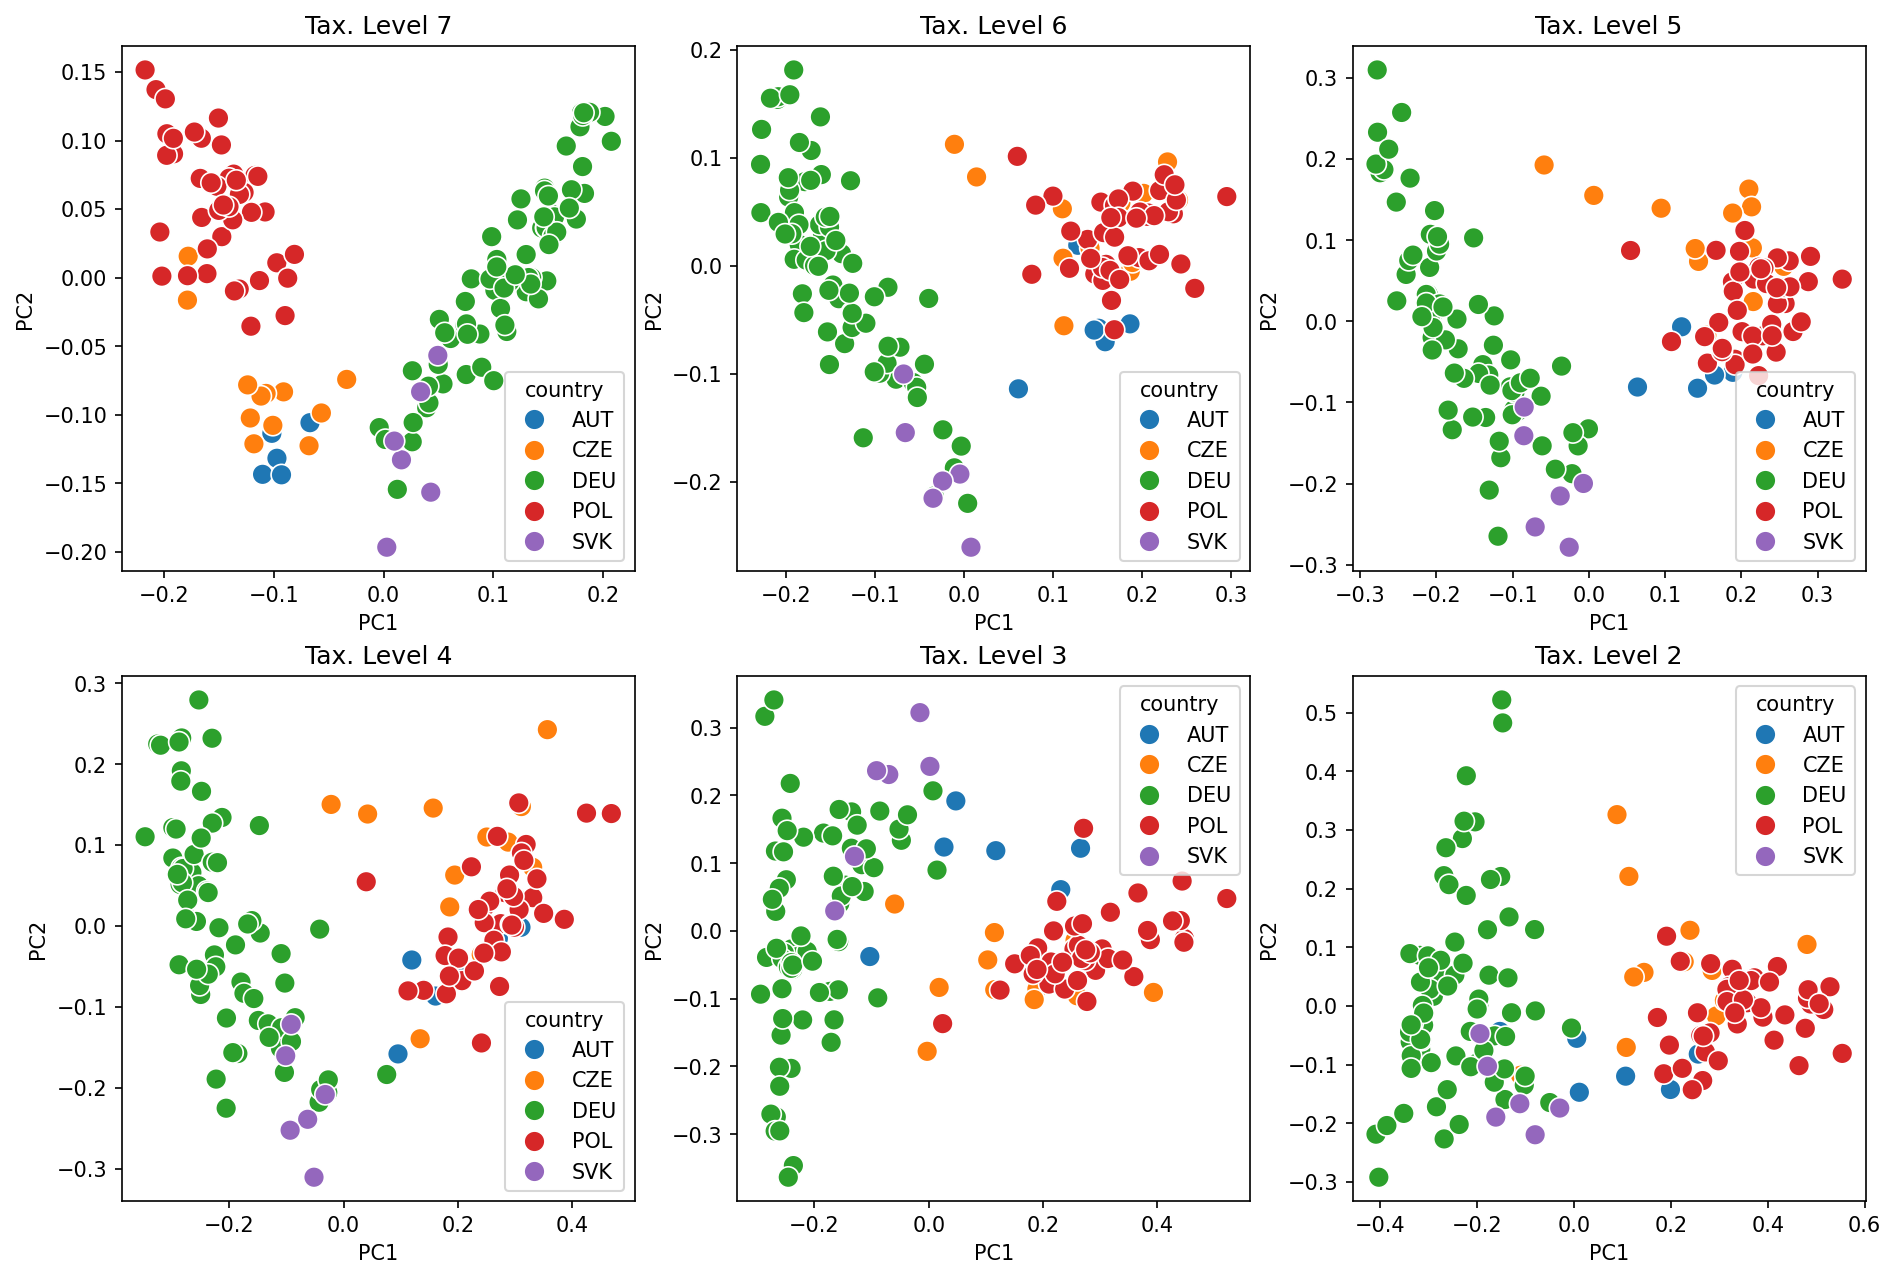

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=150)

for level, ax in zip(range(7, 1, -1), axes.flatten()):
    df = generate_pca_plot_at_level(level)
    sns.scatterplot(x="PC1", y="PC2", hue='country', data=df, s=100, ax=ax)
    ax.set_title(f'Tax. Level {level}')

In [16]:
level=7
df = generate_pca_plot_at_level(level)
population = fuas.set_index('eFUA_name').loc[df['city'].values, 'FUA_p_2015'].values
df['population'] = population

[0.01710804 0.00593765] [0.31507762 0.10935323]


In [28]:
import jscatter
scatter = jscatter.Scatter(data=df, x='PC1', y='PC2', color_by='country', size=8, tooltip=True, tooltip_properties=["city", "population"])
scatter.show()

In [ ]:
level = 7

sns.scatterplot(x="PC1", y="PC2", hue='country', data=df, size=population.values)